## Regression

In this lecture, I will bring together various techniques for feature engineering that we have covered in this course to tackle a regression problem. This would give you an idea of the end-to-end pipeline to build machine learning algorithms for regression.

I will:
- build a lasso
- use feature-engine for the feature engineering steps
- set up an entire engineering and prediction pipeline using a Scikit-learn Pipeline

===================================================================================================

## In this demo:

We will use the House Prices dataset, please refer to lecture **Datasets** in Section 1 of the course for instructions on how to download the dataset.

## House Prices dataset

In [86]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce

### models implemented
from catboost import CatBoostRegressor

pd.pandas.set_option('display.max_columns', None)

### Load Datasets

In [87]:
# load dataset
data = pd.read_csv('houseprice.csv')

print(data.shape)

data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Types of variables (section 2)

Let's go ahead and find out what types of variables there are in this dataset

In [88]:
# let's inspect the type of variables in pandas

data.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

There are a mixture of categorical and numerical variables. Numerical are those of type **int** and **float** and categorical those of type **object**.

In [89]:
# we have an Id variable, that we should not use for predictions:

print('Number of House Id labels: ', len(data.Id.unique()))
print('Number of Houses in the Dataset: ', len(data))

Number of House Id labels:  1460
Number of Houses in the Dataset:  1460


Id is a unique identifier for each of the houses. Thus this is not a variable that we can use.

#### Find categorical variables

In [90]:
# find categorical variables

categorical = [var for var in data.columns if data[var].dtype=='O']

print('There are {} categorical variables'.format(len(categorical)))

There are 43 categorical variables


In [91]:
data[categorical].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


#### Find temporal variables

There are a few variables in the dataset that are temporal. They indicate the year in which something happened. We shouldn't use these variables straightaway for model building. We should instead transform them to capture some sort of time information. Let's inspect these temporal variables:


In [92]:
# make a list of the numerical variables first
numerical = [var for var in data.columns if data[var].dtype!='O']

# list of variables that contain year information
year_vars = [var for var in numerical if 'Yr' in var or 'Year' in var]

year_vars

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [93]:
data[year_vars].head()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
0,2003,2003,2003.0,2008
1,1976,1976,1976.0,2007
2,2001,2002,2001.0,2008
3,1915,1970,1998.0,2006
4,2000,2000,2000.0,2008


We can see that these variables correspond to the years in which the houses were built or remodeled or a garage was built, or the house was indeed sold. It would be better if we captured the time elapsed between the time the house was built and the time the house was sold for example. We are going to do that in the feature engineering section later in the notebook. 

We have another temporal variable: MoSold, which indicates the month in which the house was sold. Let's inspect if the house price varies with the time of the year in which it is sold:

Text(0, 0.5, 'median House price')

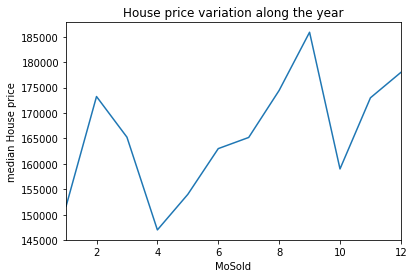

In [94]:
# plot median house price per month in which it was sold

data.groupby('MoSold')['SalePrice'].median().plot()
plt.title('House price variation along the year')
plt.ylabel('median House price')

The price seems to vary depending on the month in which the house is sold.

#### Find discrete variables

To identify discrete variables, I will select from all the numerical ones, those that contain a finite and small number of distinct values. See below.

In [95]:
# let's visualise the values of the discrete variables
discrete = []

for var in numerical:
    if len(data[var].unique()) < 20 and var not in year_vars:
        print(var, ' values: ', data[var].unique())
        discrete.append(var)
print()
print('There are {} discrete variables'.format(len(discrete)))

MSSubClass  values:  [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
OverallQual  values:  [ 7  6  8  5  9  4 10  3  1  2]
OverallCond  values:  [5 8 6 7 4 2 3 9 1]
BsmtFullBath  values:  [1 0 2 3]
BsmtHalfBath  values:  [0 1 2]
FullBath  values:  [2 1 3 0]
HalfBath  values:  [1 0 2]
BedroomAbvGr  values:  [3 4 1 2 0 5 6 8]
KitchenAbvGr  values:  [1 2 3 0]
TotRmsAbvGrd  values:  [ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces  values:  [0 1 2 3]
GarageCars  values:  [2 3 1 0 4]
PoolArea  values:  [  0 512 648 576 555 480 519 738]
MoSold  values:  [ 2  5  9 12 10  8 11  4  1  7  3  6]

There are 14 discrete variables


#### Continuous variables

In [96]:
# find continuous variables
# let's remember to skip the Id variable and the target variable SalePrice
# which are both also numerical

numerical = [var for var in numerical if var not in discrete and var not in [
    'Id', 'SalePrice'] and var not in year_vars]

print('There are {} numerical and continuous variables'.format(len(numerical)))

There are 18 numerical and continuous variables


Perfect!! Now we have inspected and have a view of the different types of variables that we have in the house price dataset. Let's move on to understand the types of problems that these variables have.

### Types of problems within the variables (section 3)

#### Missing values

The majority of the continuous variables seem to contain outliers. In addition, the majority of the variables are not normally distributed. As we are planning to build linear regression, we need to tackle these to improve the model performance. To tackle the 2 aspects together, I will do discretisation. I will follow discretisation with encoding of the intervals following the target mean, as we do in the **Discretisation plus encoding lecture** in section 8.

#### Outliers in discrete variables

Now, let's identify outliers in the discrete variables. I will call outliers those values that are present in less than 5 % of the houses. This is exactly the same as finding rare labels in categorical variables. **Discrete variables can be pre-processed / engineered as if they were categorical**. Keep this in mind.

Some of the discrete variables show some sort of monotonic relationship and some don't.

#### Number of labels: cardinality

Let's go ahead now and examine the cardinality of our categorical variables. That is, the number of different labels.

Text(0, 0.5, 'Number of different categories')

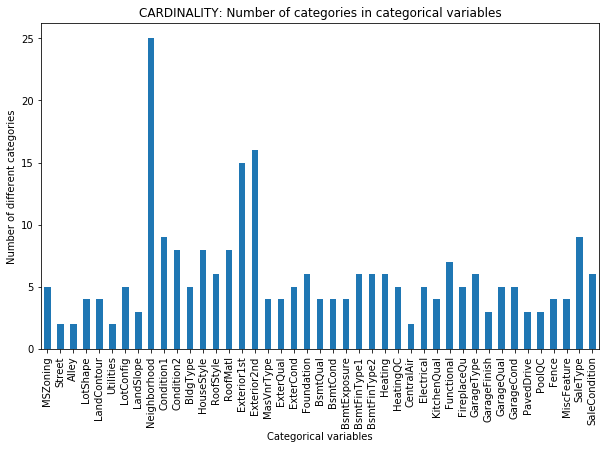

In [97]:
# plot number of categories per categorical variable

data[categorical].nunique().plot.bar(figsize=(10,6))
plt.title('CARDINALITY: Number of categories in categorical variables')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')

Most of the variables, contain only a few labels. Then, we do not have to deal with high cardinality. That is good news!

Very likely though, they contain rare labels. Why don't you go ahead and plot the frequency of the categories for each categorical variable? We learned how to do this in section 3 of the course.

### Separate train and test set

In [98]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(['Id', 'SalePrice'], axis=1),
                                                    data['SalePrice'],
                                                    test_size=0.1,
                                                    random_state=0)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

**Now we will move on and engineer the features of this dataset. The most important part for this course.**

### Temporal variables (Section 12)

First, we will create those temporal variables we discussed a few cells ago

In [99]:
# function to calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

In [100]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [101]:
X_train[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']].head()

,YearBuilt,YearRemodAdd,GarageYrBlt
930,2,2,2.0
656,49,2,49.0
45,5,5,5.0
1348,9,9,9.0
55,44,44,44.0


Instead of the "year", now we have the amount of **years that passed** since the house was built or remodeled and the house was sold. Next, we drop the YrSold variable from the datasets, because we already extracted its value.

In [102]:
# drop YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [103]:
# capture the column names for use later in the notebook
final_columns = X_train.columns

### Missing data imputation (section 4)
#### Continuous variables

In [104]:
X_train[categorical].columns 

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [105]:
X_train[discrete].columns

Index(['MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'PoolArea', 'MoSold'],
      dtype='object')

In [106]:
X_train[numerical].columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'MiscVal'],
      dtype='object')

In [107]:
# print variables with missing data
# keep in mind that now that we created those new temporal variables, we
# are going to treat them as numerical and continuous:

# remove YrSold from the variable list
# because it is no longer in our dataset
year_vars.remove('YrSold')

# examine percentage of missing values
for col in numerical+year_vars:
    if X_train[col].isnull().mean() > 0:
        print(col, X_train[col].isnull().mean())

LotFrontage 0.17732115677321156
MasVnrArea 0.0045662100456621
GarageYrBlt 0.0563165905631659


Imputation technique to use: **additional variable with NA + median imputation**

Imputation technique to use: **Add missing label to categorical variables**

## Putting it all together

In [108]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [109]:
house_pipe = Pipeline([

    # missing data imputation - section 4
    ('missing_ind', mdi.AddNaNBinaryImputer(
        variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    ('imputer_num', mdi.MeanMedianImputer(imputation_method='median',
                                          variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    ('imputer_cat', mdi.CategoricalVariableImputer(variables=categorical)),

    # categorical encoding - section 6
    ('rare_label_enc', ce.RareLabelCategoricalEncoder(
        tol=0.05, n_categories=6, variables=categorical+discrete)),
    ('categorical_enc', ce.OrdinalCategoricalEncoder(
        encoding_method='ordered', variables=categorical+discrete)),

    # discretisation + encoding - section 8
    ('discretisation', dsc.EqualFrequencyDiscretiser(
        q=5, return_object=True, variables=numerical)),
    ('encoding', ce.OrdinalCategoricalEncoder(
        encoding_method='ordered', variables=numerical)),

    # feature Scaling - section 10
    #('scaler', StandardScaler()),
    
    # regression
    #('lasso', Lasso(random_state=0))
    ('regression',CatBoostRegressor(max_depth= 6 ,learning_rate=0.01))
])

In [110]:
# let's fit the pipeline
house_pipe.fit(X_train, y_train)

# let's get the predictions
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

0:	learn: 78492.8631200	total: 7.6ms	remaining: 7.59s
1:	learn: 78036.4657606	total: 13.2ms	remaining: 6.6s
2:	learn: 77580.1351266	total: 16.7ms	remaining: 5.54s
3:	learn: 77081.7529212	total: 19.6ms	remaining: 4.88s
4:	learn: 76640.2747927	total: 22.6ms	remaining: 4.49s
5:	learn: 76160.3720127	total: 25.5ms	remaining: 4.22s
6:	learn: 75649.6701341	total: 28ms	remaining: 3.98s
7:	learn: 75198.4546890	total: 30.2ms	remaining: 3.75s
8:	learn: 74754.3920337	total: 33.8ms	remaining: 3.72s
9:	learn: 74289.2406306	total: 37.5ms	remaining: 3.71s
10:	learn: 73891.4683254	total: 40.3ms	remaining: 3.62s
11:	learn: 73417.1479804	total: 42.9ms	remaining: 3.54s
12:	learn: 72988.6914734	total: 45.3ms	remaining: 3.44s
13:	learn: 72557.2354846	total: 47.5ms	remaining: 3.34s
14:	learn: 72115.3453238	total: 49.8ms	remaining: 3.27s
15:	learn: 71683.3237548	total: 52.1ms	remaining: 3.2s
16:	learn: 71275.4874147	total: 54.5ms	remaining: 3.15s
17:	learn: 70901.9565791	total: 57.2ms	remaining: 3.12s
18:	lea

197:	learn: 32646.4107469	total: 544ms	remaining: 2.2s
198:	learn: 32561.8823550	total: 547ms	remaining: 2.2s
199:	learn: 32476.4718649	total: 550ms	remaining: 2.2s
200:	learn: 32383.2681808	total: 553ms	remaining: 2.2s
201:	learn: 32295.2118424	total: 555ms	remaining: 2.19s
202:	learn: 32204.5579976	total: 558ms	remaining: 2.19s
203:	learn: 32113.4907244	total: 561ms	remaining: 2.19s
204:	learn: 32036.4069505	total: 564ms	remaining: 2.19s
205:	learn: 31954.2123769	total: 567ms	remaining: 2.19s
206:	learn: 31867.1234295	total: 569ms	remaining: 2.18s
207:	learn: 31775.2824372	total: 574ms	remaining: 2.19s
208:	learn: 31693.0393367	total: 577ms	remaining: 2.18s
209:	learn: 31600.0596467	total: 579ms	remaining: 2.18s
210:	learn: 31510.0630035	total: 582ms	remaining: 2.18s
211:	learn: 31421.0098625	total: 584ms	remaining: 2.17s
212:	learn: 31337.3991301	total: 588ms	remaining: 2.17s
213:	learn: 31257.1917101	total: 590ms	remaining: 2.17s
214:	learn: 31175.0371624	total: 593ms	remaining: 2.

397:	learn: 23271.9095125	total: 1.08s	remaining: 1.63s
398:	learn: 23244.5523951	total: 1.08s	remaining: 1.63s
399:	learn: 23224.1015184	total: 1.08s	remaining: 1.62s
400:	learn: 23201.5952775	total: 1.08s	remaining: 1.62s
401:	learn: 23177.7132544	total: 1.09s	remaining: 1.62s
402:	learn: 23151.1546024	total: 1.09s	remaining: 1.61s
403:	learn: 23126.3023072	total: 1.09s	remaining: 1.61s
404:	learn: 23107.4918299	total: 1.1s	remaining: 1.61s
405:	learn: 23077.5224026	total: 1.1s	remaining: 1.61s
406:	learn: 23054.3656512	total: 1.1s	remaining: 1.6s
407:	learn: 23038.2722876	total: 1.1s	remaining: 1.6s
408:	learn: 23015.2861320	total: 1.1s	remaining: 1.6s
409:	learn: 22993.1022185	total: 1.11s	remaining: 1.59s
410:	learn: 22967.1252641	total: 1.11s	remaining: 1.59s
411:	learn: 22944.4493421	total: 1.11s	remaining: 1.59s
412:	learn: 22921.2755677	total: 1.12s	remaining: 1.59s
413:	learn: 22893.0765405	total: 1.12s	remaining: 1.58s
414:	learn: 22871.1943772	total: 1.12s	remaining: 1.58s


546:	learn: 20577.5011385	total: 1.43s	remaining: 1.19s
547:	learn: 20565.9567280	total: 1.44s	remaining: 1.19s
548:	learn: 20555.2031784	total: 1.44s	remaining: 1.18s
549:	learn: 20536.0058406	total: 1.44s	remaining: 1.18s
550:	learn: 20522.3344851	total: 1.45s	remaining: 1.18s
551:	learn: 20510.7025876	total: 1.45s	remaining: 1.18s
552:	learn: 20501.9071988	total: 1.45s	remaining: 1.17s
553:	learn: 20491.1490938	total: 1.45s	remaining: 1.17s
554:	learn: 20476.9321131	total: 1.46s	remaining: 1.17s
555:	learn: 20457.6884433	total: 1.46s	remaining: 1.17s
556:	learn: 20445.1092904	total: 1.46s	remaining: 1.16s
557:	learn: 20435.1501372	total: 1.46s	remaining: 1.16s
558:	learn: 20424.4426298	total: 1.47s	remaining: 1.16s
559:	learn: 20413.9340791	total: 1.47s	remaining: 1.15s
560:	learn: 20406.8322612	total: 1.47s	remaining: 1.15s
561:	learn: 20396.0041807	total: 1.47s	remaining: 1.15s
562:	learn: 20380.2382508	total: 1.48s	remaining: 1.15s
563:	learn: 20372.4514565	total: 1.48s	remaining

766:	learn: 18406.5828380	total: 1.98s	remaining: 601ms
767:	learn: 18392.4396856	total: 1.98s	remaining: 598ms
768:	learn: 18384.9850488	total: 1.98s	remaining: 596ms
769:	learn: 18378.1865004	total: 1.99s	remaining: 593ms
770:	learn: 18366.2538281	total: 1.99s	remaining: 591ms
771:	learn: 18351.9094472	total: 1.99s	remaining: 588ms
772:	learn: 18346.9207304	total: 1.99s	remaining: 586ms
773:	learn: 18336.3575861	total: 2s	remaining: 583ms
774:	learn: 18327.7260725	total: 2s	remaining: 581ms
775:	learn: 18319.7564201	total: 2s	remaining: 578ms
776:	learn: 18308.0024905	total: 2s	remaining: 575ms
777:	learn: 18303.7080956	total: 2.01s	remaining: 573ms
778:	learn: 18294.9747680	total: 2.01s	remaining: 570ms
779:	learn: 18285.0597113	total: 2.01s	remaining: 567ms
780:	learn: 18274.9889812	total: 2.01s	remaining: 565ms
781:	learn: 18264.1684769	total: 2.02s	remaining: 562ms
782:	learn: 18257.5847604	total: 2.02s	remaining: 559ms
783:	learn: 18247.5171789	total: 2.02s	remaining: 557ms
784:

914:	learn: 17304.2299900	total: 2.32s	remaining: 215ms
915:	learn: 17300.0495592	total: 2.32s	remaining: 213ms
916:	learn: 17291.5869249	total: 2.33s	remaining: 210ms
917:	learn: 17287.9070690	total: 2.33s	remaining: 208ms
918:	learn: 17278.3664860	total: 2.33s	remaining: 205ms
919:	learn: 17270.7146935	total: 2.33s	remaining: 203ms
920:	learn: 17265.7826373	total: 2.34s	remaining: 200ms
921:	learn: 17260.9319613	total: 2.34s	remaining: 198ms
922:	learn: 17254.4097904	total: 2.34s	remaining: 195ms
923:	learn: 17245.5846554	total: 2.34s	remaining: 193ms
924:	learn: 17237.1624202	total: 2.35s	remaining: 190ms
925:	learn: 17232.6918570	total: 2.35s	remaining: 188ms
926:	learn: 17229.0363200	total: 2.35s	remaining: 185ms
927:	learn: 17223.2295180	total: 2.35s	remaining: 183ms
928:	learn: 17221.4616860	total: 2.36s	remaining: 180ms
929:	learn: 17212.2320986	total: 2.36s	remaining: 178ms
930:	learn: 17203.4483785	total: 2.36s	remaining: 175ms
931:	learn: 17193.1279058	total: 2.36s	remaining

In [111]:
# a peek into the prediction values
X_train_preds

array([216595.58642965, 155048.0686069 , 305363.90454351, ...,
       127141.59757094, 203321.04718923, 205832.89137801])

In [118]:
# check model performance:           
print('train mae: {}'.format(mean_absolute_error(y_train, X_train_preds) , 2) )
print('train r2: {}'.format(r2_score(y_train, X_train_preds),2))
print()
print('test mae: {}'.format(mean_absolute_error(y_test, X_test_preds),2) )
print('test r2: {}'.format(r2_score(y_test, X_test_preds),2))

train mae: 12309.373661521386
train r2: 0.9548230878062501

test mae: 16720.37850249152
test r2: 0.8654715906492172


Text(0, 0.5, 'Predicted Price')

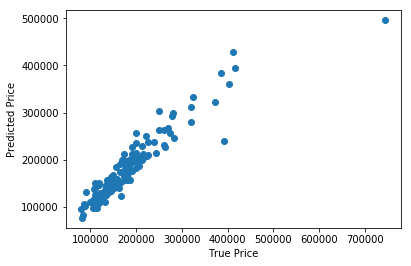

In [84]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')